In [1]:
import time
s = time.time()
from methods_fromhome import *
import geopandas as gpd
import pandas as pd



bfe = gpd.read_file('bfe_mre_all_poc2.shp')
fsp = gpd.read_file('fsp_2.shp')
fl = gpd.read_file('flowline_poc2.shp')

# Reproject files to UTM
bfe.to_crs(26913, inplace=True)
bfe = bfe[['ELEV', 'geometry']]
print('ORIGINAL BFE SHAPE', bfe.shape)
fsp.to_crs(26913, inplace=True)
fsp = fsp[['geometry']]
fsp.reset_index(inplace=True)

fl.to_crs(26913, inplace=True)
fl = fl[['geometry']]
fl.reset_index(inplace=True)

# Correct broken BFEs if there is any
bfe_bfe = bfe.sjoin(bfe, how='left')
bfe_bfe.reset_index(inplace=True)
brok = bfe_bfe.loc[bfe_bfe['index'] != bfe_bfe['index_right']]
if brok.shape[0] > 0:
    brok_geoms = brok[['index', 'geometry']]
    fix = brok.merge(brok_geoms, left_on='index_right', right_on='index')
    fix['new_geom'] = fix.apply(lambda x: linemerge(list((x.geometry_x, x.geometry_y))), axis=1)
    fix_gpd = gpd.GeoDataFrame(fix[['index_x', 'ELEV_left', 'new_geom']], geometry='new_geom', crs=26913)
    fix_gpd.rename(columns={'index_x': 'index', 'ELEV_left': 'ELEV', 'new_geom': 'geometry'}, inplace=True)
    fix_gpd.set_index('index', inplace=True)
    bfe_clean = bfe.loc[~bfe.index.isin(fix_gpd.index)]
    bfe = pd.concat([bfe_clean, fix_gpd])
    bfe = bfe.drop_duplicates('geometry')
   

# Extend BFEs over FSP Poly then reset bfe to new position
bfe_extend = extend_bfe(bfe, fsp)
bfe = bfe_extend.clip(fsp)

# Split FSP Poly by extended BFEs
fsp_s = split_fsp(fsp, bfe_extend)

# Split Flowline by BFEs
fl = split_flowline(fl, bfe)

# Find forks and place in list
forks_ls = find_forks(fl)

# Create Flowline Buffer
fl['buff'] = fl.apply(lambda x: x.geometry.buffer(1))
fl_buff = fl.set_geometry('buff', crs=26913)
fl_buff = fl_buff[['buff']]
fl = fl[['geometry']]

# get fl_segs that are forks
all_fsegs_forks = [segs for e in forks_ls for segs in e]

fl_non_forks = fl.loc[~fl.index.isin(all_fsegs_forks)].reset_index()
fl_buff_non_forks = fl_buff.loc[~fl_buff.index.isin(all_fsegs_forks)].reset_index()




ORIGINAL BFE SHAPE (413, 2)


In [2]:
triangles = gpd.GeoDataFrame()
for i, f in fl_non_forks.iterrows():
    fl_buff_i = fl_buff_non_forks.loc[fl_buff_non_forks['index'] == f['index']]
    print(i)
    bfe_set = bfe.sjoin(fl_buff_i, how='left', predicate='intersects')
    bfe_set = bfe_set.loc[bfe_set['index_right'].notnull()]
    bfe_set = bfe_set[['ELEV', 'geometry']]

    # Remove MultiLineString BFEs caused by potential line overlap with FSP poly
    bfe_set = remove_multiline_BFE(bfe_set)
    if bfe_set.shape[0] != 2:
        pass
    else:
        # Getting Z-geom for BFE Points
        bfe_pts = bfe_zpts(bfe_set)

        # BFE Centroid and Flowline interpolation
        fl_i_pts = flowline_interpolation(bfe_set, 
                                            f,
                                            line_segs=None,
                                            buff_segments=None, 
                                            divisions=10, 
                                            power=2
        )
        
        # Create Z geometry for flowline
        fl_i_pts = ELEV_2geom(fl_i_pts)
    
        # FSP Simplify
        fsp_pts = fsp_pts_simplify(fsp_s, fl_i_pts, tolerance=3)

        # FSP Interpolation
        fsp_i_pts = IDW(bfe_set, fsp_pts, power=2)

        # Create Z geometry for FSP Poly
        fsp_i_pts = ELEV_2geom(fsp_i_pts)

        # Concat and Triangulate
        all_pts = pd.concat([bfe_pts, fl_i_pts, fsp_i_pts], ignore_index=True)
        all_pts_multigeom = MultiPoint(all_pts.geometry.to_list())


        tin = triangulate(all_pts_multigeom)
        tin_df = g(tin, 26913)
    
        # Extract Geom
        final_tin = extract_geom(tin_df)
        triangles = pd.concat([triangles, final_tin], ignore_index=True)
        

        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [74]:
#bfe_set['multiline'] = bfe_set.apply(lambda x: for i in [y for y in x.geometry])
if 'MultiLineString' in bfe_set.geom_type.to_list():
    multi_geom = bfe_set.loc[bfe_set.geom_type == 'MultiLineString']
    lines = multi_geom.explode()
    max_line = lines.loc[lines.geometry.length == max(lines.geometry.length)]
    print(max_line)
    bfe_set = bfe_set.loc[~bfe_set.index.isin(multi_geom.index)]
    bfe_set = pd.concat([bfe_set, max_line], ignore_index=True)
    print(bfe_set)

       ELEV                                           geometry
20 1  686.0  LINESTRING (1257131.125 3640115.020, 1257147.3...
    ELEV                                           geometry
0  688.0  LINESTRING (1257085.964 3640091.496, 1257116.2...
1  686.0  LINESTRING (1257131.125 3640115.020, 1257147.3...


In [76]:
bfe_set.to_file('bfe_set_test.shp')

In [3]:
triangles.to_file('new_tin3.shp')

In [24]:
bfe.to_file('bfe_REAL.shp')

In [9]:
for g in tin_df.geometry:
    print(g)

POLYGON ((1256924.9371760173 3638350.4515159284, 1256925.6531090767 3638338.609042522, 1256925.71563164 3638338.5819103206, 1256924.9371760173 3638350.4515159284))
POLYGON ((1256924.9371760173 3638350.4515159284, 1256925.71563164 3638338.5819103206, 1256939.2864460554 3638341.3426568033, 1256924.9371760173 3638350.4515159284))
POLYGON ((1256924.9371760173 3638350.4515159284, 1256939.2864460554 3638341.3426568033, 1256939.1439233017 3638368.7170723113, 1256924.9371760173 3638350.4515159284))
POLYGON ((1256924.9371760173 3638350.4515159284, 1256939.1439233017 3638368.7170723113, 1256939.135359692 3638368.76371742, 1256924.9371760173 3638350.4515159284))
POLYGON Z ((1256938.666876951 3638330.2775243097 703, 1256946.1172242188 3638330.734213792 701, 1256946.1114360539 3638330.7657413366 0, 1256938.666876951 3638330.2775243097 703))
POLYGON Z ((1256938.666876951 3638330.2775243097 703, 1256946.1114360539 3638330.7657413366 0, 1256939.2864460554 3638341.3426568033 0, 1256938.666876951 363833

In [90]:
# Check if broken BFEs exist
bfe_bfe = bfe.sjoin(bfe, how='left')
bfe_bfe.reset_index(inplace=True)
brok = bfe_bfe.loc[bfe_bfe['index'] != bfe_bfe['index_right']]



In [91]:
brok_geoms = brok[['index', 'geometry']]
df = brok.merge(brok_geoms, left_on='index_right', right_on='index')

In [92]:
df

,index_x,ELEV_left,geometry_x,index_right,ELEV_right,index_y,geometry_y
0,33,609.0,"LINESTRING (1261258.166 3638859.447, 1261329.6...",138,609.0,138,"LINESTRING (1261071.506 3638792.603, 1261134.4..."
1,79,653.0,"LINESTRING (1258614.204 3638679.106, 1258646.7...",328,653.0,328,"LINESTRING (1258646.711 3638659.199, 1258664.2..."
2,138,609.0,"LINESTRING (1261071.506 3638792.603, 1261134.4...",33,609.0,33,"LINESTRING (1261258.166 3638859.447, 1261329.6..."
3,173,584.0,"LINESTRING (1263338.616 3637974.712, 1263350.5...",225,584.0,225,"LINESTRING (1263350.563 3638000.491, 1263369.7..."
4,174,585.0,"LINESTRING (1263283.783 3637954.479, 1263295.2...",227,585.0,227,"LINESTRING (1263335.177 3638201.657, 1263362.5..."
5,225,584.0,"LINESTRING (1263350.563 3638000.491, 1263369.7...",173,584.0,173,"LINESTRING (1263338.616 3637974.712, 1263350.5..."
6,227,585.0,"LINESTRING (1263335.177 3638201.657, 1263362.5...",174,585.0,174,"LINESTRING (1263283.783 3637954.479, 1263295.2..."
7,272,515.0,"LINESTRING (1269975.500 3635299.497, 1269929.6...",391,515.0,391,"LINESTRING (1269518.109 3634858.830, 1269453.4..."
8,273,516.0,"LINESTRING (1269506.894 3635003.558, 1269637.9...",392,516.0,392,"LINESTRING (1269402.335 3634869.795, 1269493.7..."
9,274,517.0,"LINESTRING (1269493.271 3635179.348, 1269646.7...",393,517.0,393,"LINESTRING (1269360.858 3634944.980, 1269444.5..."


In [93]:
df = brok.merge(brok_geoms, left_on='index_right', right_on='index')
df['new_geom'] = df.apply(lambda x: linemerge(list((x.geometry_x, x.geometry_y))), axis=1)
df = gpd.GeoDataFrame(df[['index_x', 'ELEV_left', 'new_geom']], geometry='new_geom', crs=26913)
df

,index_x,ELEV_left,new_geom
0,33,609.0,"LINESTRING (1261071.506 3638792.603, 1261134.4..."
1,79,653.0,"LINESTRING (1258614.204 3638679.106, 1258646.7..."
2,138,609.0,"LINESTRING (1261071.506 3638792.603, 1261134.4..."
3,173,584.0,"LINESTRING (1263338.616 3637974.712, 1263350.5..."
4,174,585.0,"LINESTRING (1263283.783 3637954.479, 1263295.2..."
5,225,584.0,"LINESTRING (1263338.616 3637974.712, 1263350.5..."
6,227,585.0,"LINESTRING (1263283.783 3637954.479, 1263295.2..."
7,272,515.0,"LINESTRING (1269975.500 3635299.497, 1269929.6..."
8,273,516.0,"LINESTRING (1269402.335 3634869.795, 1269493.7..."
9,274,517.0,"LINESTRING (1269360.858 3634944.980, 1269444.5..."


In [94]:
df.rename(columns={'index_x': 'index', 'ELEV_left': 'ELEV', 'new_geom': 'geometry'}, inplace=True)
df

,index,ELEV,geometry
0,33,609.0,"LINESTRING (1261071.506 3638792.603, 1261134.4..."
1,79,653.0,"LINESTRING (1258614.204 3638679.106, 1258646.7..."
2,138,609.0,"LINESTRING (1261071.506 3638792.603, 1261134.4..."
3,173,584.0,"LINESTRING (1263338.616 3637974.712, 1263350.5..."
4,174,585.0,"LINESTRING (1263283.783 3637954.479, 1263295.2..."
5,225,584.0,"LINESTRING (1263338.616 3637974.712, 1263350.5..."
6,227,585.0,"LINESTRING (1263283.783 3637954.479, 1263295.2..."
7,272,515.0,"LINESTRING (1269975.500 3635299.497, 1269929.6..."
8,273,516.0,"LINESTRING (1269402.335 3634869.795, 1269493.7..."
9,274,517.0,"LINESTRING (1269360.858 3634944.980, 1269444.5..."


In [96]:
df.set_index('index', inplace=True)
df

,ELEV,geometry
index,,
33,609.0,"LINESTRING (1261071.506 3638792.603, 1261134.4..."
79,653.0,"LINESTRING (1258614.204 3638679.106, 1258646.7..."
138,609.0,"LINESTRING (1261071.506 3638792.603, 1261134.4..."
173,584.0,"LINESTRING (1263338.616 3637974.712, 1263350.5..."
174,585.0,"LINESTRING (1263283.783 3637954.479, 1263295.2..."
225,584.0,"LINESTRING (1263338.616 3637974.712, 1263350.5..."
227,585.0,"LINESTRING (1263283.783 3637954.479, 1263295.2..."
272,515.0,"LINESTRING (1269975.500 3635299.497, 1269929.6..."
273,516.0,"LINESTRING (1269402.335 3634869.795, 1269493.7..."


In [98]:
bfe.update(df)
bfe.to_file('new_bfes.shp')


In [2]:
bfe_extend.to_file('bfe_extendPOC2.shp')

In [28]:
df = g(bfe.geometry[0], 26913)

In [29]:
df

,geometry
0,"LINESTRING (1261040.169 3638877.426, 1261065.5..."


In [35]:
df.geometry.boundary.to_list()[0][0].coords[0]

(1261040.1688958886, 3638877.425863135)

In [36]:
coords = list((df.geometry.boundary.to_list()[0][0].coords[0], df.geometry.boundary.to_list()[0][1].coords[0]))
coords

[(1261040.1688958886, 3638877.425863135),
 (1261297.2110216361, 3639046.980258827)]

In [37]:
df['points'] = df.apply(lambda x: list((x.geometry.boundary.to_list()[0][0].coords[0], x.geometry.boundary.to_list()[0][1].coords[0])))
df

,geometry,points
0,"LINESTRING (1261040.169 3638877.426, 1261065.5...","(1261040.1688958886, 3638877.425863135)"


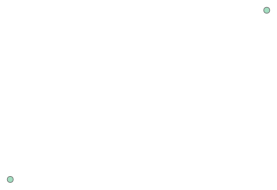

In [49]:
bfe = bfe.iloc[0]
bfe.geometry.boundary

In [4]:
bfe['points'] = bfe['geometry'].apply(lambda x: list((x.boundary[0].coords[0], x.boundary[1].coords[0])))
for x in 

,ELEV,geometry,points
0,610.0,"LINESTRING (1261040.169 3638877.426, 1261065.5...","[(1261040.1688958886, 3638877.425863135), (126..."
1,610.0,"LINESTRING (1263052.733 3639399.056, 1263112.2...","[(1263052.733461782, 3639399.0562684136), (126..."
2,610.0,"LINESTRING (1261749.039 3639459.828, 1261785.7...","[(1261749.0390453446, 3639459.827910773), (126..."
3,612.0,"LINESTRING (1260869.845 3638966.923, 1260870.4...","[(1260869.8451304776, 3638966.923480152), (126..."
4,613.0,"LINESTRING (1263024.323 3639529.343, 1263068.3...","[(1263024.322846053, 3639529.342939181), (1263..."
...,...,...,...
408,559.0,"LINESTRING (1265749.612 3636393.264, 1265751.4...","[(1265749.611553322, 3636393.2643690757), (126..."
409,559.0,"LINESTRING (1265648.080 3637220.186, 1265682.2...","[(1265648.079532531, 3637220.1858273656), (126..."
410,560.0,"LINESTRING (1265456.506 3637040.896, 1265454.3...","[(1265456.506442627, 3637040.8959248993), (126..."
411,561.0,"LINESTRING (1265325.558 3637063.607, 1265322.8...","[(1265325.5580489342, 3637063.6072940463), (12..."


In [2]:
import time
s = time.time()
from methods_fromhome import *
import geopandas as gpd
import pandas as pd



bfe = gpd.read_file('bfe_mre_all_poc2.shp')
fsp = gpd.read_file('fsp_2.shp')
fl = gpd.read_file('flowline_poc2.shp')

# Reproject files to UTM
bfe.to_crs(26913, inplace=True)
bfe = bfe[['ELEV', 'geometry']]

fsp.to_crs(26913, inplace=True)
fsp = fsp[['geometry']]
fsp.reset_index(inplace=True)

fl.to_crs(26913, inplace=True)
fl = fl[['geometry']]
fl.reset_index(inplace=True)

# Extend BFEs over FSP Poly
bfe_extend = extend_bfe(bfe, fsp)
